## Building The Country Page Widgets

Charlie has added the following dataset to the **PRODUCTION** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


Note: many queries will be repeated, but the data used in different ways, so we should cache the responses for re-use.

```
{'dataset': '499682b1-3174-493f-ba1a-368b4636708e'}
```


https://production-api.globalforestwatch.org/v1/query/?sql=SELECT polyname, year_data.year, sum(year_data.area_loss) as sum FROM data WHERE polyname = 'wdpa'  and iso = 'BRA' GROUP BY polyname, iso, nested(year_data.year)


In [1]:
import requests
import requests_cache
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
requests_cache.install_cache('demo_cache')

Testing basic queries

**notes**

* New table structure includes `bound1-4` which provide an additional attribute to group by

```
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT polyname, count(*) FROM data WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname
```

This one table should be enough to generate data for areas of interest from admin0 to admin 2 level on its own.

In [2]:
ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [10]:
# Example of what is in the data tables and how to simply read them:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'plantations' LIMIT 3")
#sql = (f"SELECT polyname, count(*) FROM {ds} WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname")
#sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'bra_biomes' LIMIT 1")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+%2A+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27+LIMIT+3
Status: 200


{'data': [{'_id': 'AWAxmrFzVdtBxrrI-ELN',
   'adm1': 21,
   'adm2': 3996,
   'area_extent': 272.539381382,
   'area_gadm28': 46336.5056967,
   'area_poly_aoi': 0.0005256770160869999,
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   'iso': 'BRA',
   'polyname': 'plantations',
   'thresh': 30,
   'year_data': [{'area_loss': 22.5652762038,
     'emissions': 2730.2836196999997,
     'year': 2001},
    {'area_loss': 12.457381895, 'emissions': 1583.29179307, 'year': 2002},
    {'area_loss': 51.2981066753, 'emissions': 6408.22109205, 'year': 2003},
    {'area_loss': 23.844706895500003,
     'emissions': 3056.61808058,
     'year': 2004},
    {'area_loss': 5.28884876152, 'emissions': 703.6756682999999, 'year': 2005},
    {'area_loss': 0, 'emissions': 0, 'year': 2006},
    {'area_loss': 10.4421938269, 'emissions': 1178.70421511, 'year': 2007},
    {'area_loss': 31.4736056864, 'emissions': 4094.99730405, 'year': 2008},
   

The `polyname` attribute in the data indicates the geometry used in the intersection. E.g. `polyname`:`gadm28` means that the GADM28 polygons alone were used, therefore `area_extent` would be the value of the Hansen 2010 tree cover extent within a particular gadm28 geometry.

Charlie has used a convention of mutliple underscores to indicate when data has multiple intersects. The rule is as follows:
* All data are intersected with the gadm28
* Some data are intersected with gadam + something else, in that case it takes the name of the something else, e.g. plantations
* some data are intersected with multiple gadam + multiple other data sources, in that case, the data sources are seperated by a dunder (double underscore) in the `polyname`. E.g. `primary_forest__landmark` are the gadam28 + primary forest data + landmark 

In [11]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT polyname FROM {ds} WHERE iso = 'BRA' and thresh = 0 GROUP BY polyname")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
for row in r.json().get('data'):
    print(row.get('polyname'))

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+and+thresh+%3D+0+GROUP+BY+polyname
Status: 200
bra_biomes
gadm28
mining
plantations
plantations__mining
wdpa
primary_forest
primary_forest__mining
primary_forest__wdpa
plantations__wdpa
ifl_2013
ifl_2013__wdpa
ifl_2013__mining
landmark
primary_forest__landmark
plantations__landmark


Also of note, is the `bound1-4` attributes, which are 

```
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   
```

These hold extra properties of a dataset which can be used in group-by statements, e.g. plantation data has been split into species type. 

Finally, another key property is the `area_poly_aoi`, which should hold the total area (ha) of the shape used to make the intersection. E.g., the sum of the `polyname` = gadm28 `area_poly_aoi` values should equal the total land area of a selected ROI. 


# Obtain metadata for admin0 to admin2 level

Retrieve json mappings of id values (e.g. iso codes or integers) for admin0 to admin2 level, and map them to english names for selectors and resources to build dynamic sentences.

In [12]:
def get_admin0_json(urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of iso and country names
    e.g.
    [{'iso': 'AFG', 'name': 'Afghanistan'},
     {'iso': 'XAD', 'name': 'Akrotiri and Dhekelia'},
     {'iso': 'ALA', 'name': 'Åland'},
     ...
    ]
    
    """
    sql = ("SELECT iso, country as name FROM umd_nat_staging "
            "GROUP BY iso, name "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
 

def get_admin1_json(iso, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of admin1 for a country
    e.g. for iso='GBR'
        [{'adm1': 1, 'name': 'England'},
         {'adm1': 2, 'name': 'Northern Ireland'},
         {'adm1': 3, 'name': 'Scotland'},
         {'adm1': 4, 'name': 'Wales'}]
    """
    sql = ("SELECT id1 as adm1, region as name "
            "FROM umd_subnat_staging "
            f"WHERE iso = '{iso}' "
            "and year = 2001 "
            "and thresh = 30 "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
   

def get_admin2_json(iso, adm1, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """ 
    e.g. response for iso='GBR' adm1=1
    [{'adm2': 1, 'name': 'Barking and Dagenham'},
     {'adm2': 2, 'name': 'Bath and North East Somerset'},
     ...
     ]

    """
    sql = ("SELECT id_2 as adm2, name_2 as name "
            "FROM gadm28_adm2 "
            f"WHERE iso = '{iso}' "
            f"AND id_1 = {adm1} "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})    
    return r.json().get('rows', None)

In [13]:
tmp = get_admin0_json()
iso_to_countries = {}
for row in tmp:
    iso_to_countries[row.get('iso')] = row.get('name')

# Get info on an areas shape

Use the Geostore service to find the geometry, bounding box or additional info on a given `iso` or `iso/admin1` area if required (e.g. for centering the map).

Note - if similar info is needed for admin2 areas I will have to go back and create a query based on a Carto table, as admin-2 level data does not exist in the geostore service yet.

In [14]:
iso = "GBR"
adm1 = None 

if not adm1:
    print("returning admin-0 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}"
else:
    print("returning admin-1 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}"
    
r = requests.get(url)
print(r.url)
roi = r.json()

print(roi.get('data', None).get('attributes', None).keys())
roi.get('data').get('attributes').get('bbox')  #e.g. of getting the bounding box of a ROI

returning admin-0 level geostore
https://api.resourcewatch.org/v1/geostore/admin/GBR
dict_keys(['geojson', 'hash', 'provider', 'areaHa', 'bbox', 'lock', 'info'])


[-13.6913900375365, 49.8654174804688, 1.76416802406322, 60.8458213806153]

In [15]:
def create_bounding_poly(bbox):
    """Create a bounding polygon from a returned bbox of the geostore service
        (- the old api produced shapes in this format).
    """
    lat1, lon1, lat2, lon2  = bbox
    return [[lat1,lon1], [lat1,lon2],[lat2,lon2],[lat2,lon1] ,[lat1,lon1]]

In [16]:
create_bounding_poly(roi.get('data').get('attributes').get('bbox'))

[[-13.6913900375365, 49.8654174804688],
 [-13.6913900375365, 60.8458213806153],
 [1.76416802406322, 60.8458213806153],
 [1.76416802406322, 49.8654174804688],
 [-13.6913900375365, 49.8654174804688]]

# Set up global (scope) data sources for the Country Widgets 

There is some work that needs to be done in populating the Location menu, not all options should be always available: some of them will need to be iso dependent. E.g. `Biomes` should only appear in the menu if the ISO is set to `BRA`


In [17]:
polynames = {
                'All Region':'gadm28',
                'Biomes':'bra_biomes',
                'Mining':'mining',
                'Protected Areas':'wdpa',
                'Primary Forests':'primary_forest',
                'Mining in Primary Forests':'primary_forest__mining',
                'Protected Areas in Primary Forests':'primary_forest__wdpa',
                'Intact Forest Landscapes':'ifl_2013',
                'Protected Areas in Intact Forest Landscapes':'ifl_2013__wdpa',
                'Mining in Intact Forest Landscapes':'ifl_2013__mining',
                'Indigenous Lands':'landmark',
                'Indigenous Lands in Primary Forests':'primary_forest__landmark',
                'Plantations':'plantations',
                'Mining in Plantation Areas':'plantations__mining',
                'Protected areas in Plantations':'plantations__wdpa',
                'Indigenous Lands in Plantations':'plantations__landmark',
            }

# Tree cover widget

The default view for the tree cover widget should be for 'All Region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.


For the default  "All Region" location, we will need to show 3 slices in the donut chart:
    * Tree plantations
    * Natural forest (tree cover 2010 - tree plantations)
    * Non-forest (total area - tree cover 2010)

We show how to calculate this below.

**BUT**

If other Locations are selected, (e.g. Protected Areas), we need a different donut chart. One with less data (only tree cover, and non-forest).

    * Tree cover 
    * Non-forest



*Notes: below this line are extra notes not needed for Front-end dev*

- adm0 = BRA, adm1 = 4  is Amazonas
- adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
- adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
- adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
- adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)


In [18]:
# # Example of what is in the data tables and how to simply read them:
# url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
# sql = (f"SELECT * FROM {ds} WHERE polyname = 'plantations' LIMIT 2")
# #sql = (f"SELECT polyname, count(*) FROM {ds} WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname")
# #sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'bra_biomes' LIMIT 1")
# properties = {"sql": sql}
# r = requests.get(url, params = properties)
# print(r.url)
# print(f'Status: {r.status_code}')
# r.json()

In [32]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None
location = 'All Region'  

In [33]:
def extent_queries(p_name, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM(area_extent) as value "
               f"SUM(area_gadm28) as total_area, "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_extent) as value "
               f"SUM(area_gadm28) as total_area, "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM(area_extent) as value "
               f"SUM(area_gadm28) as total_area, "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

In [34]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 
        
print(areaId_to_name)

None


In [35]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value+SUM%28area_gadm28%29+as+total_area%2C+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%20SUM%28area_gadm28%29%20as%20total_area%2C%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha
total area = 850033236.0091553 ha


** Gather PLANTATION data also if needed  **

In [39]:
# For some locations we will also need to retrieve an area for plantations
# This is the area of UMD forest cover intersecting tree plantations at admin2 level

if location in ['All Region']:
    sql = extent_queries(p_name=polynames['Plantations'], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data neded for '{location}'")
    plantations = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value+SUM%28area_gadm28%29+as+total_area%2C+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 660671465.5681152, 'value': 4660023.699318573}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%20SUM%28area_gadm28%29%20as%20total_area%2C%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 4660023.699318573 ha


In [40]:
#  Note if plantations are 0 - this situation should be considered the same as if plantation data 
# were not to be included. I.e. if plantation = 0 then 

if location in ['All Region']:
    print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2010:g}, area={total_area:g}")
else:
    print(f"tree cover={tree_cover_extent_2010:g}, area={total_area:g}")

plantations=4.66002e+06, tree cover=5.19188e+08, area=8.50033e+08


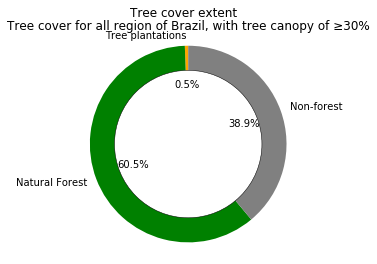

In [41]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")


if location in ['All Region']: 
    labels = 'Tree plantations', 'Natural Forest', 'Non-forest'
    sizes = [plantations, tree_cover_extent_2010 - plantations, total_area - tree_cover_extent_2010]
    colors = ['orange','green','grey']
else: 
    labels = 'Tree cover', 'Non-forest'
    sizes = [tree_cover_extent_2010, total_area - tree_cover_extent_2010]
    colors = ['green','grey']
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

## FAO FOREST Widget

This widget should include 'FOREST COVER ' in the title - note the distinction, that the Hansen data relate to tree cover, and FAO relate to forest cover...

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [ ]:
# For FAO data, only country (admin0) level data are avaiable. No other options on selector.

# Variables
adm0 = 'BRA'

In [ ]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

fao_percent = r.json().get('rows')[0]

In [ ]:
# How to calculate the statitics needed based on the CARTO responses

naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

In [ ]:
# FAO donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

In [ ]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

In [ ]:
# Dyanmic sentence for FAO plot

print(f"FAO data from 2015 shows that {iso_to_countries[adm0]} is ", end="")

if  non_forest/fao_percent['area_ha'] > 0.5:
    print('mostly non-forest. ', end="")
else:
    print('mostly forest. ',end="")

if primary_forest > 0:
    print(f"Primary forest occupies {primary_forest/fao_percent['area_ha']*100:3.1f}% of the country. ", end="")
    print(f"This gives {iso_to_countries[adm0]} a rank of {rank}th out of 110 countries in terms of ", end="")
    print("its relative amount of primary forest.")

## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


** WHen plantations are selected the user should see a stacked bar chart  from 2013 onwards **
More details of this to follow below.


In [ ]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = 4
adm2 = 141
start=2000
end=2016
location = "All Region"

In [ ]:
f"SELECT polyname, year_data.year, sum(year_data.area_loss) as sum "
f"FROM data "
f"WHERE polyname = 'wdpa' " 
f"and iso = 'BRA' "
f"GROUP BY polyname, iso, nested(year_data.year)"

In [ ]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

```
{'data': [{'_id': 'AWAxmrFzVdtBxrrI-ELN',
   'adm1': 21,
   'adm2': 3996,
   'area_extent': 272.539381382,
   'area_gadm28': 46336.5056967,
   'area_poly_aoi': 0.0005256770160869999,
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   'iso': 'BRA',
   'polyname': 'plantations',
   'thresh': 30,
   'year_data': [{'area_loss': 22.5652762038,
     'emissions': 2730.2836196999997,
     'year': 2001},
    {'area_loss': 12.457381895, 'emissions': 1583.29179307, 'year': 2002},
    {'area_loss': 51.2981066753, 'emissions': 6408.22109205, 'year': 2003},
    {'area_loss': 23.844706895500003,
     'emissions': 3056.61808058,
     'year': 2004},
    {'area_loss': 5.28884876152, 'emissions': 703.6756682999999, 'year': 2005},
    {'area_loss': 0, 'emissions': 0, 'year': 2006},
    {'area_loss': 10.4421938269, 'emissions': 1178.70421511, 'year': 2007},
    {'area_loss': 31.4736056864, 'emissions': 4094.99730405, 'year': 2008},
    {'area_loss': 1.1387181114799998,
     'emissions': 139.328357637,
     'year': 2009},
    {'area_loss': 0, 'emissions': 0, 'year': 2010},
    {'area_loss': 0.334869382846, 'emissions': 26.3877124208, 'year': 2011},
    {'area_loss': 2.47792299302, 'emissions': 156.974708267, 'year': 2012},
    {'area_loss': 5.491153023890001,
     'emissions': 453.07059737300006,
     'year': 2013},
    {'area_loss': 13.258465667100001,
     'emissions': 1002.21233838,
     'year': 2014},
    {'area_loss': 3.2126014871900006,
     'emissions': 246.56177485400002,
     'year': 2015},
    {'area_loss': 4.6198582657,
     'emissions': 332.55653858700003,
     'year': 2016}]}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
     'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20%2A%20FROM%20499682b1-3174-493f-ba1a-368b4636708e%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27%20LIMIT%201'}},
   'http_method': 'POST',
   'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}
```

In [ ]:
def loss_queries(ds, adm0, start, end, adm1=None, adm2=None, threshold=30):
    if adm2:
        print(f'Request for adm2 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh={threshold} "
               "GROUP BY year ")
    return sql



Loss on hover should show % loss relative to Tree cover extent in the year 2010, over the appropriate
region. I.e. if someone is interested in the 'All region' default view, then the loss should come from the `gadm28 loss` table, and the extent (to calculate the relative loss) should come from the `gadm28 extent` table.

Therefore we must calculate loss % also.

In [ ]:
url = "https://staging-api.globalforestwatch.org/query"

# First, get the 2010 tree cover extent for your area of interest
sql = extent_queries(ds=data_sources.get(location).get('extent'),
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
print(sql)  # 2010 extent query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())
y2010_relative_extent = r.json().get('data')[0].get('value')


# Next, get the loss data grouped by year
sql = loss_queries(ds=data_sources.get(location).get('loss'), adm0=adm0, start=start, end=end, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

# Extract the year, and loss in hectares, and emissions units, and calculate the relative loss in %
d = {}
for row in r.json().get('data'):
    d[row.get('year')] = {'area_ha': row.get('area'),
                          'area_%': row.get('area')/y2010_relative_extent * 100,
                          'emissions': row.get('emissions'),
                          }
pprint(d)

In [ ]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f'{iso_to_countries[adm0]} tree cover loss for {location.lower()}')
if adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} tree cover loss for {location.lower()}")
if adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} tree cover loss for {location.lower()}")


loss = [val.get('area_ha') for val in d.values()]
years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, loss, width, color='#FE5A8D')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(dynamic_title)
plt.show()

** ISSUE **

* How is there plantations loss over such a long period? (I was expecting it to start in 2013 only...)

I need to check this with Charlie before I construct the plantations (inside/outside stacked bar version).

** build the dynamic sentence itself for the Tree cover loss widget **

Charlie has confirmed that he has simply intersected hansen data with available polygons. This approach will produce data for times when it doesnt make sense that it exists: need to account for this - do not enable plantation loss before 2013.

#### Dynamic sentence 

For the loss widget we also need a dynamic sentence.

In [ ]:
for year in d:
    print(year, d.get(year).get('emissions'), d.get(year).get('area_ha'))

In [ ]:
# First find total emissions, and loss, and also the last year of emissions and loss

total_emissions = 0
total_loss = 0
for year in d:
    total_loss += d.get(year).get('area_ha')
    total_emissions += d.get(year).get('emissions')

print([total_emissions, total_loss])

In [ ]:
# Dynamic sentence construction

if adm0 and not adm1 and not adm2:
    print(f"Between {start} and {end}, {iso_to_countries[adm0]} ({location.lower()}) ", end="")
if adm0 and adm1 and not adm2: 
    print(f"Between {start} and {end},  {location} of {areaId_to_name[adm1].lower()} ", end="")
if adm0 and adm1 and adm2:
    print(f"Between {start} and {end}, {location} of {areaId_to_name[adm2].lower()} ", end="")
    
print(f"lost {total_loss:,.0f} ha of tree cover: ", end="")
print(f"This loss is equal to {total_loss / y2010_relative_extent * 100:3.2f}% of the total ", end="")
print(f"{location.lower()} tree cover extent in 2010, ", end="")
print(f"and equivalent to {total_emissions:,.0f} tonnes of CO\u2082 emissions. ", end="")

## HEADER DYNAMIC SENTENCE

The page header needs to contain a dynamic sentence; this sentence is built from the same data tables (and most of the same queries) that we have already used. (Which is why I am describing it here, rather than at the start of the notebook.)

The sentence should be able to account for edge cases where no loss occured (as people will end up looking at admin 2 areas) which may be relativley small, and possibly have no loss.

Be prepared for the need to increase the complexity/comprehensivness of the header sentence over time.

In [ ]:
def extract_loss(json_data, last_year=2016):
    """Grab the last loss year of data for area and emissions"""
    for row in json_data:
        if row.get('year') == last_year:
            last_loss = row.get('area')
            last_emissions = row.get('emissions')
    return {'area':last_loss, 'emissions':last_emissions}

In [ ]:
last_year = 2016
threshold = 30
adm0 = 'BRA'
adm1 = 14
adm2 = None

In [ ]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [ ]:
# Get the plantation last year data for the region of interest

sql = loss_queries(ds=data_sources.get('Tree Plantations').get('loss'), adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold, start=start, end = end)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
plantation_values = extract_loss(plantation_loss_json, last_year=last_year)
print(plantation_values)

In [ ]:
# Get the gadm28 loss 
gadm28_loss_table = "88994c38-1ea1-4a32-82ca-073547d11176"

sql = loss_queries(ds=data_sources.get('All Region').get('loss'), adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold, start=start, end = end)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
gadm28_values = extract_loss(plantation_loss_json, last_year=last_year)
print(gadm28_values)

In [ ]:
# Get total land area (ha) of selected region  - hopefully we can change this soon to use a
# table inthe data_source

sql = area_queries(adm0=adm0, adm1=adm1, adm2=adm2)

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

total_area = r.json().get('rows')[0].get('value')
#print(f"\n {total_area} ha total area selected")

In [ ]:
# Get 2010 tree cover extent of selected area from gadm28 table 

sql = extent_queries(ds=data_sources.get('All Region').get('extent'), adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")


In [ ]:
# DYNAMIC SENTENCE

if adm0 and not adm1 and not adm2:
    print(f"In 2010, {iso_to_countries[adm0]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")     
if adm0 and adm1 and not adm2: 
    print(f"In 2010, {areaId_to_name[adm1]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")
if adm0 and adm1 and adm2:
    print(f"In 2010, {areaId_to_name[adm2]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")

percent_cover = tree_cover_extent_2010/total_area*100
if percent_cover > 0:
    print(f", extending over {percent_cover:3.1f}% of its land area. ", end="")
else:
    print(". ")

# beware we could have areas with no plantations
try:
    loss_area = int(gadm28_values['area'] - plantation_values['area'])
except:
    loss_area = 0
    
print(f"In {last_year}, ",end="")

if loss_area > 0:
    print(f"it lost {loss_area:,.0f} ha "
          "of forest excluding tree plantations, equivalent to "
          f"{int(gadm28_values['emissions'] - plantation_values['emissions']):,.0f} "
          "tonnes of CO\u2082 of emissions.")
else:
    print("it lost no tree cover (excluding tree plantations).")

# Tree Cover gain widget

1. Widgets made entireley from a dynamic sentence
2. User Variables (admin0 to admin1 and location)
3. Datasets (All GAIN datasets)


** LOCATION Area Selectors **

    - All region (GADM from admin-0 to admin-2 level)
    - Biodiversity Hotspots
    - Protected Areas
    - Plantations
    - Managed Forests
    - Primary Forests
    - Intact Forests (2000/2013)

** Notes **

- AOI (area of interest) is the gadm region (admin0-2)
- location is the subset of that (i.e protected areas)
- Threshold is not a variable in this widget (it should be hardcoded in the queries and must be set to `thresh = 0`)

In [ ]:
# Variables
adm0 = 'BRA'
adm1 = 14
adm2 = None
location = "Tree Plantations"

url = "https://staging-api.globalforestwatch.org/query"

In [ ]:
# get admin 1 or 2 level human-readable name info as needed:
areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [ ]:
#GAIN QUERY

def gain_query(ds, adm0, adm1=None, adm2 = None):
    """Queries for the gain tables. Note, threshold must be hardcoded to 0
        and that will not change.
    """
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND thresh = 0")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND thresh = 0")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = 0") 
    return sql

In [ ]:
# gain query
sql = gain_query(ds=data_sources.get(location).get('gain'), adm0=adm0, adm1=adm1, adm2=adm2)
r1 = requests.get(url, params = {"sql": sql})

try:
    tree_cover_gain_2010 = r1.json().get('data')[0].get('value')
except:
    tree_cover_gain_2010 = 0.0
print(r1.url)    
pprint(r1.json())


# Total Extent query
sql = gain_query(ds=data_sources.get(location).get('extent'), adm0=adm0, adm1=adm1, adm2=adm2)
r2 = requests.get(url, params = {"sql": sql})
print(r2.url)
pprint(r2.json())

total_area = r2.json().get('data')[0].get('value')
area_percent = round((100 * tree_cover_gain_2010 / total_area), 2)

In [ ]:
#Dynamic sentence

# we may need to modify the way we describe the location to fit gramatically
if location == 'All Region':
    region_phrase = 'region-wide'
else:
    region_phrase = 'in ' + location.lower()


print(f"From 2001 to 2012, ", end="")

if(not adm1 and not adm2):
    print(f"{iso_to_countries[adm0]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
elif(not adm2):
    print(f"{areaId_to_name[adm1]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
else:
    print(f"{areaId_to_name[adm2]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ", end="")
    print(f"increase relative to 2010 tree cover extent.", end="")


# Rate of Reforestation widget

Dynamic Sentence based on FAO data in a Carto table. Only works for admin-0 (countries).


e.g. dynamic sentences:

"Between `X` and `Y` years, the rate of reforestation in `country name` was `X` ha/year."


** Options**

Users should be able to select period from a dropdown menu in the settings:
* Period: ['1990–2000', '2000–2005', '2005–2010', '2010–2015']

** Notes**

- Default should be the most recent period (`2010–2015`).
- The value that comes back from the query is kha not ha : i.e. it is in ha/1000 by default.

In [ ]:
# Human readable option for the Period selector, and a key that it should relate to for its query.
fao_periods = {'1990–2000': 1990, '2000–2005':2000, '2005–2010':2005, '2010–2015':2010}


# Variables
adm0 = 'GBR'
period = '2010–2015'

In [ ]:
# First, get the FAO data from a carto table. Note that extent is multiplied by 1000.

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
         "FROM table_1_forest_area_and_characteristics as fao "
         f"WHERE fao.year = {fao_periods[period]} "
         f"AND fao.country = '{adm0}'"
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

data = r.json().get('rows')[0]

In [ ]:
#Dynamic sentence

print(f"From {period}, the rate of reforestation in {data['name']} was {data['rate']*1000:,.0f} ha/year. ", end="")